In [15]:
import random
import matplotlib.pyplot as plt
from collections import Counter
import networkx as nx

In [9]:
# Alphabet
Sigma = ['A', 'C', 'G', 'T']

# generate n strings with random length between min_len and max_len with characters from Sigma
n = 10
min_len = 1
max_len = 5


In [10]:
strings = []

for i in range(n):
    length = random.randint(min_len, max_len)
    string = ''.join(random.choices(Sigma, k=length))
    strings.append(string)

print(strings)

['AGTAA', 'GGACT', 'ATGGC', 'TGCCA', 'C', 'A', 'GGG', 'GCAT', 'ACAG', 'TCC']


In [13]:
# create a counter for each string
counters = [Counter(string) for string in strings]

[Counter({'A': 3, 'G': 1, 'T': 1}), Counter({'G': 2, 'A': 1, 'C': 1, 'T': 1}), Counter({'G': 2, 'A': 1, 'T': 1, 'C': 1}), Counter({'C': 2, 'T': 1, 'G': 1, 'A': 1}), Counter({'C': 1}), Counter({'A': 1}), Counter({'G': 3}), Counter({'G': 1, 'C': 1, 'A': 1, 'T': 1}), Counter({'A': 2, 'C': 1, 'G': 1}), Counter({'C': 2, 'T': 1})]


In [28]:
# generate a random DAG with n nodes
G = nx.gnr_graph(n, 0.5, seed=None)

# associate to each node a counter
for i, counter in enumerate(counters):
    G.nodes[i]['counter'] = counter

print(G.nodes.data())

[(0, {'counter': Counter({'A': 3, 'G': 1, 'T': 1})}), (1, {'counter': Counter({'G': 2, 'A': 1, 'C': 1, 'T': 1})}), (2, {'counter': Counter({'G': 2, 'A': 1, 'T': 1, 'C': 1})}), (3, {'counter': Counter({'C': 2, 'T': 1, 'G': 1, 'A': 1})}), (4, {'counter': Counter({'C': 1})}), (5, {'counter': Counter({'A': 1})}), (6, {'counter': Counter({'G': 3})}), (7, {'counter': Counter({'G': 1, 'C': 1, 'A': 1, 'T': 1})}), (8, {'counter': Counter({'A': 2, 'C': 1, 'G': 1})}), (9, {'counter': Counter({'C': 2, 'T': 1})})]


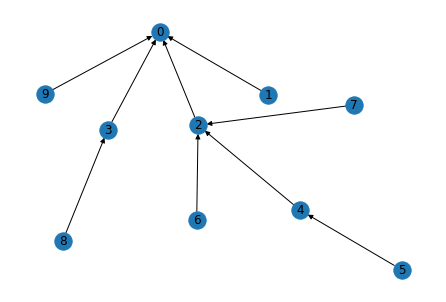

In [29]:
# draw the graph
nx.draw(G, with_labels=True)

In [31]:
# do a topological sort and associate to each node the id of the node in the topological order
topological_order = list(nx.topological_sort(G))
for i, node in enumerate(topological_order):
    G.nodes[node]['topological_order'] = i

print(G.nodes.data())

[(0, {'counter': Counter({'A': 3, 'G': 1, 'T': 1}), 'topological_order': 9}), (1, {'counter': Counter({'G': 2, 'A': 1, 'C': 1, 'T': 1}), 'topological_order': 0}), (2, {'counter': Counter({'G': 2, 'A': 1, 'T': 1, 'C': 1}), 'topological_order': 8}), (3, {'counter': Counter({'C': 2, 'T': 1, 'G': 1, 'A': 1}), 'topological_order': 7}), (4, {'counter': Counter({'C': 1}), 'topological_order': 6}), (5, {'counter': Counter({'A': 1}), 'topological_order': 1}), (6, {'counter': Counter({'G': 3}), 'topological_order': 2}), (7, {'counter': Counter({'G': 1, 'C': 1, 'A': 1, 'T': 1}), 'topological_order': 3}), (8, {'counter': Counter({'A': 2, 'C': 1, 'G': 1}), 'topological_order': 4}), (9, {'counter': Counter({'C': 2, 'T': 1}), 'topological_order': 5})]


In [32]:
# create a table with two cols, the this is (min, node_id) and the second is (max, node_id)

import pandas as pd

table = pd.DataFrame(columns=['min', 'max'])
